## 6. XGBoost
https://tianchi.aliyun.com/course/278/3423

> XGBoost 是16年华盛顿大学陈天奇老师带领开发的一个可扩展机器学习系统。严格意义上讲XGBoost并不是一种模型，而是一个可供用户解决分类、回归或排序问题的软件包。
> XGBoost内部实现了梯度提升树（GBDT）模型，并对模型中的算法进行了诸多优化，在取得高精度的同时保持极快的速度。
> 更重要的是，XGBoost在系统优化和机器学习原理方面都进行了深入的考虑。毫不夸张的讲，XGBoost提供的可扩展性，可移植性与准确性推动了机器学习计算限制的上限，该系统在单台机器上运行速度比当时流行解决方案快十倍以上，甚至在分布式系统中可以处理十亿级的数据。

#### Note:

### 6.1 Theoretical part 

Advantage:
+ easy to use with satisfied result
+ highly extendable; fast on large-scale dataset; low requirement for hardware resources
+ high robustness; no need for subtle parameter tuning
+ internal GBDT, automatically dealing with NaNs

Disadvantage:
+ cannot capture features for high dimensional data, like images, video, text
+ when have a large amount of training data and can find a suitable deep learning model, the accuracy of deep learning can be far ahead of XGBoost

> XGBoost在机器学习与数据挖掘领域有着极为广泛的应用。据统计在2015年Kaggle平台上29个获奖方案中，17只队伍使用了XGBoost；在2015年KDD-Cup中，前十名的队伍均使用了XGBoost，且集成其他模型比不上调节XGBoost的参数所带来的提升。这些实实在在的例子都表明，XGBoost在各种问题上都可以取得非常好的效果。

> 同时，XGBoost还被成功应用在工业界与学术界的各种问题中。例如商店销售额预测、高能物理事件分类、web文本分类;用户行为预测、运动检测、广告点击率预测、恶意软件分类、灾害风险预测、在线课程退学率预测。虽然领域相关的数据分析和特性工程在这些解决方案中也发挥了重要作用，但学习者与实践者对XGBoost的一致选择表明了这一软件包的影响力与重要性。


XGBoost底层实现了GBDT算法，并对GBDT算法做了一系列优化：

+ 对目标函数进行了泰勒展示的二阶展开，可以更加高效拟合误差。
+ 提出了一种估计分裂点的算法加速CART树的构建过程，同时可以处理稀疏数据。
+ 提出了一种树的并行策略加速迭代。
+ 为模型的分布式算法进行了底层优化。

XGBoost是基于CART树的集成模型，它的思想是串联多个决策树模型共同进行决策。

XGBoost采用迭代预测误差的方法串联。举个通俗的例子，我们现在需要预测一辆车价值3000元。我们构建决策树1训练后预测为2600元，我们发现有400元的误差，那么决策树2的训练目标为400元，但决策树2的预测结果为350元，还存在50元的误差就交给第三棵树……以此类推，每一颗树用来估计之前所有树的误差，最后所有树预测结果的求和就是最终预测结果.

XGBoost的基模型是CART回归树，它有两个特点：（1）CART树，是一颗二叉树。（2）回归树，最后拟合结果是连续值。


Denote $f_t(x)$ as the sum of $t$ trees, $h_t(x)$ represents the $t$th DT, define the model as follows:
$$
f_t(x) = \sum_{t=1}^T h_t(x)
$$
As the model generates iteratively, thus, on the $t$ th step, the model could be generated from ($t-1$) th model, that is:
$$
f_t(x) = f_t(x-1) + h_t(x)
$$
Each step adding the loss:
$$
r_{t,i} = y_i - f_{m-1}(x_i)
$$
, which means on each step it fits a CART tree with loss output $r_{t_i}$ adding to $f_{t-1}(x)$.

#### XGBoost important parameters

1. eta

default=0.3, through adding weight to each tree to improve robustness.

2. min_child_weight

default=1, the value of sum weight of min leaf nodes. Used to reduce overfitting, the value is large to avoid learning from local special samples; while it is too large may lead to under-fitting.  

3. max_depth

default=6, the max depthe of tree. Used to reduce overfitting, larger max_depth, more local samples would be learned.

common setting: 3-10

4. max_leaf_nodes

the number of the largest nodes, could be a replace of max_depth. When it indicates, model will igore max_depth. 

5. gamma

default=0. It indicates the min decrease of min loss function for dividing branches. The higher gamma, the more conservative the model.

6. max_delta_step

default=0, limits the max step of changing weight of each tree. If max_delta_step=0, which means no limit.

7. subsample

default=1, it controls the ramdom sampling ration on each tree.
Decreasing the value  will make the algorithm more conservative and avoid overfitting. However, if this value is set too small, it may cause underfitting.
common setting: 0.5-1

8. colsample_bytree

default=1. Used to control the ratio of the number of columns randomly sampled per tree (each column is a feature).
common setting: 0.5-1

9. colsample_bylevel

default=1. Used to control the ratio of the sampling on columns, that is each split on each level of trees.
`subsample` and  `colsample_bytree` could play the same role.

10. lambda

default=1. L2 regularization term for weights. 
This parameter is used to control the regularization part of XGBoost. Although most data scientists rarely use this parameter, this parameter can still find more uses in reducing overfitting.

11. alpha

default=1. L1 regularization term for weights. 
It can be applied in very high-dimensional situations, making the algorithm run faster.

12. scale_pos_weight

default=1. 
When the samples of each category are very unbalanced, setting this parameter to a positive value can make the algorithm converge faster.



### 6.2 Practical part 

Basic practice for predicting weather.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !wget https://tianchi-media.oss-cn-beijing.aliyuncs.com/DSW/7XGBoost/train.csv
data = pd.read_csv('train.csv')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106644 entries, 0 to 106643
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           106644 non-null  object 
 1   Location       106644 non-null  object 
 2   MinTemp        106183 non-null  float64
 3   MaxTemp        106413 non-null  float64
 4   Rainfall       105610 non-null  float64
 5   Evaporation    60974 non-null   float64
 6   Sunshine       55718 non-null   float64
 7   WindGustDir    99660 non-null   object 
 8   WindGustSpeed  99702 non-null   float64
 9   WindDir9am     99166 non-null   object 
 10  WindDir3pm     103788 non-null  object 
 11  WindSpeed9am   105643 non-null  float64
 12  WindSpeed3pm   104653 non-null  float64
 13  Humidity9am    105327 non-null  float64
 14  Humidity3pm    103932 non-null  float64
 15  Pressure9am    96107 non-null   float64
 16  Pressure3pm    96123 non-null   float64
 17  Cloud9am       66303 non-null

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,106183.000000,106413.000000,105610.000000,60974.000000,55718.000000,99702.000000,105643.000000,104653.000000,105327.000000,103932.000000,96107.000000,96123.000000,66303.000000,63691.000000,105983.000000,104599.000000
mean,12.186148,23.235895,2.346357,5.479721,7.630220,39.972227,13.992929,18.631898,68.802377,51.438181,1017.651975,1015.254297,4.438487,4.501515,16.989344,21.692755
std,6.399877,7.127716,8.413614,4.211778,3.785116,13.599543,8.873860,8.805657,19.093677,20.806300,7.105074,7.035537,2.886585,2.718442,6.497898,6.945127
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,36.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.300000,0.600000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,31.900000,48.100000,268.600000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,39.400000,46.200000


In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2012/1/19,MountGinini,12.1,23.1,0.0,NaN,NaN,W,30.0,N,...,60.0,54.0,NaN,NaN,NaN,NaN,17.0,22.0,No,No
1,2015/4/13,Nhil,10.2,24.7,0.0,NaN,NaN,E,39.0,E,...,63.0,33.0,1021.9,1017.9,NaN,NaN,12.5,23.7,No,Yes
2,2010/8/5,Nuriootpa,-0.4,11.0,3.6,0.4,1.6,W,28.0,N,...,97.0,78.0,1025.9,1025.3,7.0,8.0,3.9,9.0,Yes,No
3,2013/3/18,Adelaide,13.2,22.6,0.0,15.4,11.0,SE,44.0,E,...,47.0,34.0,1025.0,1022.2,NaN,NaN,15.2,21.7,No,No
4,2011/2/16,Sale,14.1,28.6,0.0,6.6,6.7,E,28.0,NE,...,92.0,42.0,1018.0,1014.1,4.0,7.0,19.1,28.2,No,No


In [4]:
### Fill NaNs
data = data.fillna(-1)
data.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
106639,2011/5/23,Launceston,10.1,16.1,15.8,-1.0,-1.0,SE,31.0,NNW,...,99.0,86.0,999.2,995.2,-1.0,-1.0,13.0,15.6,Yes,Yes
106640,2014/12/9,GoldCoast,19.3,31.7,36.0,-1.0,-1.0,SE,80.0,NNW,...,75.0,76.0,1013.8,1010.0,-1.0,-1.0,26.0,25.8,Yes,Yes
106641,2014/10/7,Wollongong,17.5,22.2,1.2,-1.0,-1.0,WNW,65.0,WNW,...,61.0,56.0,1008.2,1008.2,-1.0,-1.0,17.8,21.4,Yes,No
106642,2012/1/16,Newcastle,17.6,27.0,3.0,-1.0,-1.0,-1,-1.0,NE,...,68.0,88.0,-1.0,-1.0,6.0,5.0,22.6,26.4,Yes,No
106643,2014/10/21,AliceSprings,16.3,37.9,0.0,14.2,12.2,ESE,41.0,NNE,...,8.0,6.0,1017.9,1014.0,0.0,1.0,32.2,35.7,No,No


In [5]:
# Train set target amount
pd.Series(data['RainTomorrow']).value_counts()

No     82786
Yes    23858
Name: RainTomorrow, dtype: int64

Use `value_counts` to count the numbers of labels. It is found that the negative samples are greatly more than positive samples, that is so-called "data-unbalance" ptoblem.

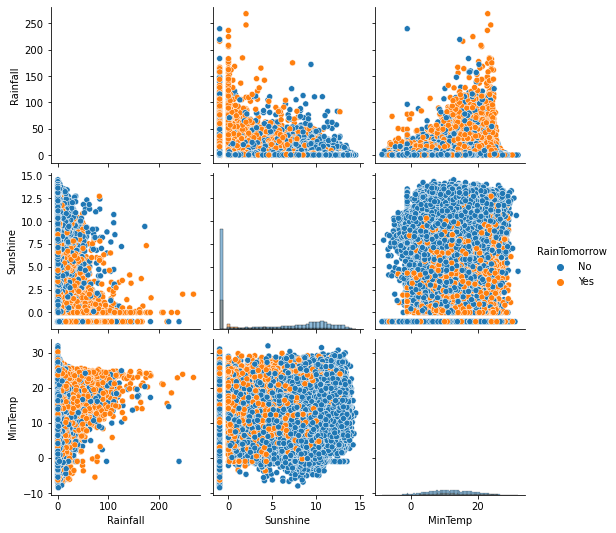

In [6]:
# Visualization 
numerical_features = [x for x in data.columns if data[x].dtype == float]
category_features = [x for x in data.columns if data[x].dtype != float and x !='RainTomorrow'] # `RainTomorrow` is the target

# Select 3 cols
sns.pairplot(data=data[['Rainfall', 'Sunshine', 'MinTemp'] + ['RainTomorrow']], diag_kind='hist', hue='RainTomorrow')
plt.show()

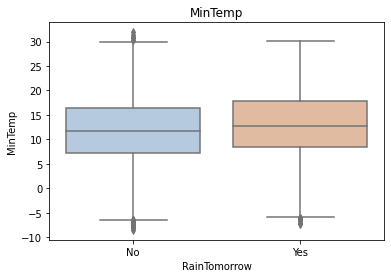

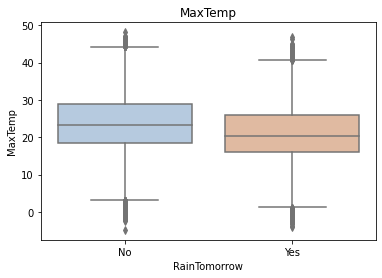

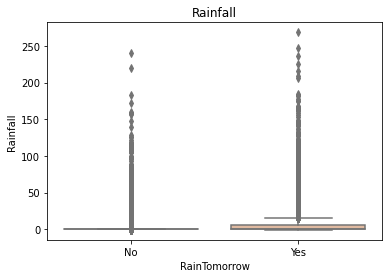

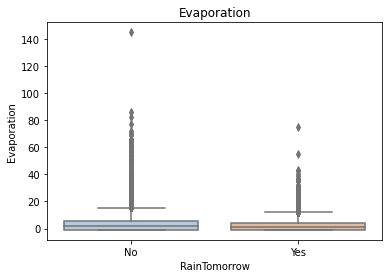

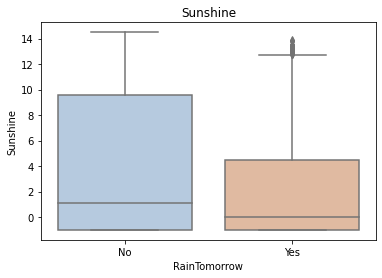

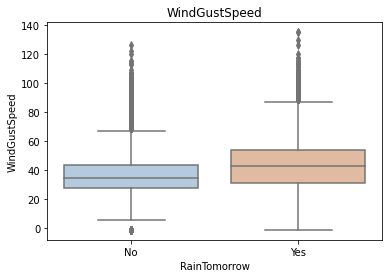

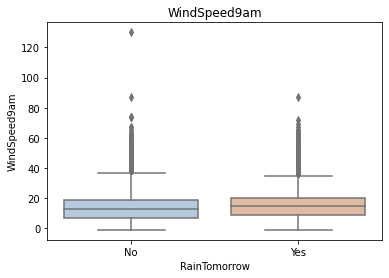

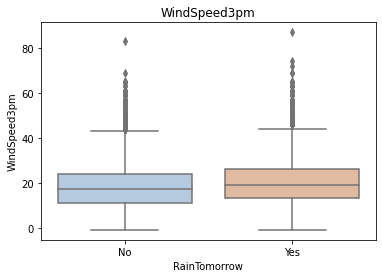

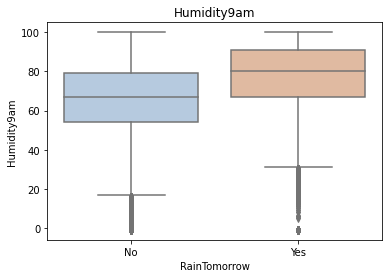

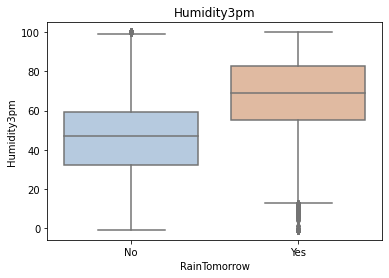

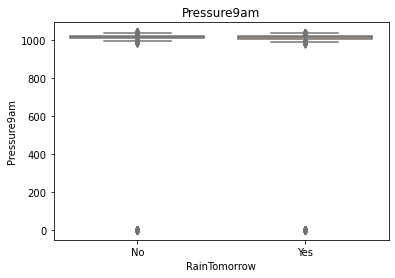

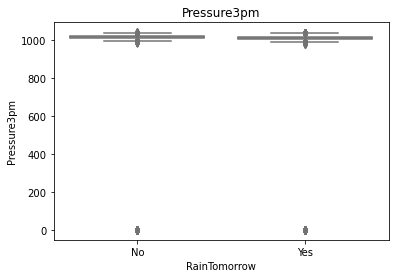

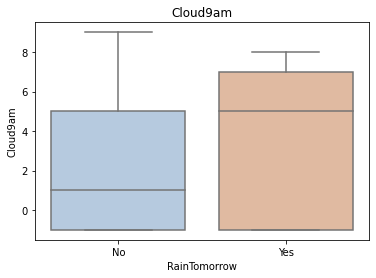

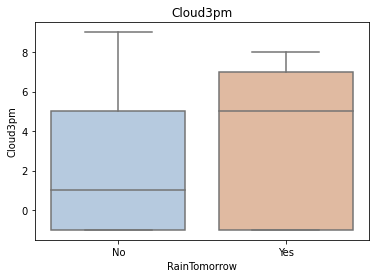

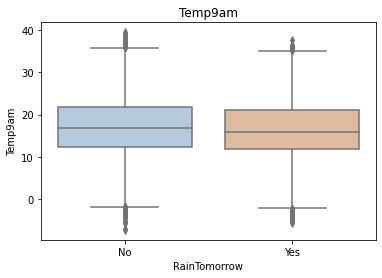

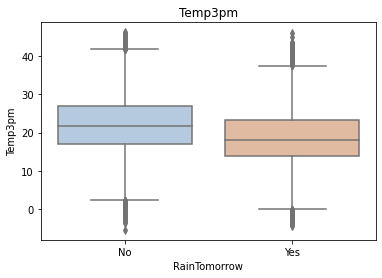

In [7]:
for col in data[numerical_features].columns:
    if col != 'RainTomorrow':
        sns.boxplot(x='RainTomorrow', y=col, saturation=.5, palette='pastel', data=data)
        plt.title(col)
        plt.show()

From the boxplots, we found that features 'Sunshine', 'Humidity3pm', 'Cloud9am', 'Cloud3pm' are relatively distinguishable.

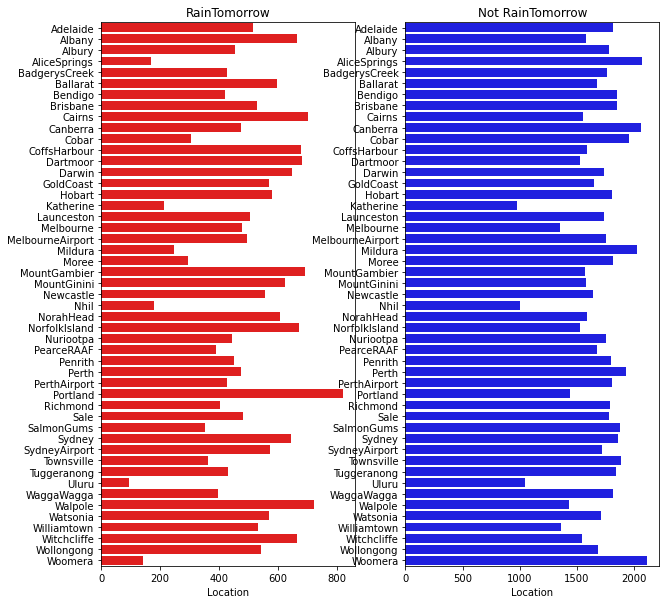

In [11]:
tlog = {}
for i in category_features:
    tlog[i] = data[data['RainTomorrow'] == 'Yes'][i].value_counts()
flog = {}
for i in category_features:
    flog[i] = data[data['RainTomorrow'] == 'No'][i].value_counts()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
sns.barplot(x = pd.DataFrame(tlog['Location']).sort_index()['Location'], y = pd.DataFrame(tlog['Location']).sort_index().index, color='red')
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x = pd.DataFrame(flog['Location']).sort_index()['Location'], y = pd.DataFrame(flog['Location']).sort_index().index, color='blue')
plt.show()

In [13]:
tlog

{'Date': 2010/9/3      29
 2009/6/2      27
 2012/7/10     27
 2015/9/2      27
 2013/6/12     26
               ..
 2008/10/5      1
 2015/10/6      1
 2010/1/15      1
 2007/11/30     1
 2008/9/16      1
 Name: Date, Length: 3163, dtype: int64,
 'Location': Portland            818
 Walpole             722
 Cairns              700
 MountGambier        692
 Dartmoor            679
 CoffsHarbour        677
 NorfolkIsland       669
 Albany              665
 Witchcliffe         663
 Darwin              645
 Sydney              642
 MountGinini         623
 NorahHead           607
 Ballarat            597
 Hobart              579
 SydneyAirport       573
 GoldCoast           569
 Watsonia            567
 Newcastle           555
 Wollongong          542
 Williamtown         532
 Brisbane            529
 Adelaide            513
 Launceston          506
 MelbourneAirport    493
 Sale                479
 Melbourne           478
 Canberra            475
 Perth               474
 Albury         

In [18]:
tlog['RainToday']

No     12422
Yes    10933
-1       503
Name: RainToday, dtype: int64

The above plots show the rainfalls varies widely from region to region, with some places being significantly more prone to rain. 

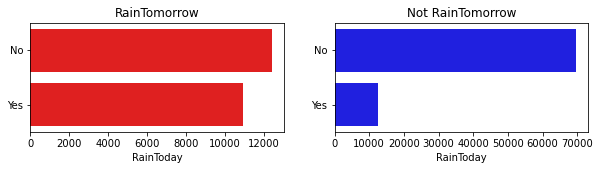

In [19]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title('RainTomorrow')
# [:2] to remove the 3rd row that represents the NaNs
sns.barplot(x = pd.DataFrame(tlog['RainToday'][:2]).sort_index()['RainToday'], y = pd.DataFrame(tlog['RainToday'][:2]).sort_index().index, color = "red")
plt.subplot(1,2,2)
plt.title('Not RainTomorrow')
sns.barplot(x = pd.DataFrame(flog['RainToday'][:2]).sort_index()['RainToday'], y = pd.DataFrame(flog['RainToday'][:2]).sort_index().index, color = "blue")
plt.show()

we can see that it does not necessarily rain tomorrow if it rains today, but if it does not rain today, there is a high probability that it will not rain the next day.

In [20]:
# Encoding discrete variables
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
    
for i in category_features:
    data[i] = data[i].apply(get_mapfunction(data[i]))

In [21]:
# To verify that 'String' features converted into 'Numerical'
data['Location'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

In [24]:
# Predict
from sklearn.model_selection import train_test_split

data_target_part = data['RainTomorrow']
data_features_part = data[[x for x in data.columns if x !='RainTomorrow']]

# Train : Test = 80% : 20%
X_tr, X_te, y_tr, y_te = train_test_split(data_features_part, data_target_part, test_size=0.2, random_state=2020)

In [25]:
# conda install -c conda-forge py-xgboost
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier()

clf.fit(X_tr, y_tr)

d:\softs\ANACONDA\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\softs\ANACONDA\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:48:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
tr_pred =  clf.predict(X_tr)
te_pred = clf.predict(X_te)

from sklearn import metrics

print('The accuracy of the Logistic Regression is :', metrics. accuracy_score(y_tr, tr_pred))
print('The accuracy of the Logistic Regression is :', metrics. accuracy_score(y_te, te_pred))

The accuracy of the Logistic Regression is : 0.8982476703979371
The accuracy of the Logistic Regression is : 0.8575179333302076


The confusion matrix result: 
 [[15656  2142]
 [  897  2634]]


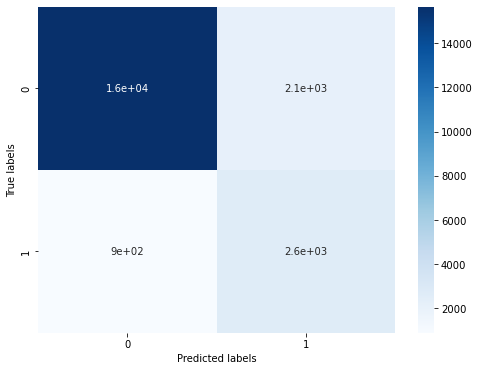

In [29]:
# confusion matrix
confusion_mat_res = metrics.confusion_matrix(te_pred, y_te)
print('The confusion matrix result: \n', confusion_mat_res)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat_res, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In total, there were 15656+2634 samples predicted correctly, 2142+897 samples predicted wrongly.

<AxesSubplot:>

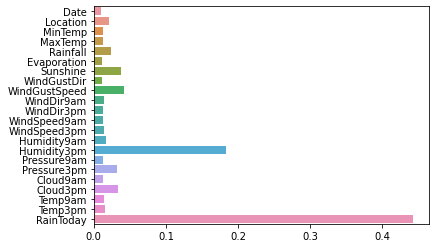

In [30]:
# Check features importance
sns.barplot(y=data_features_part.columns, x=clf.feature_importances_)

The most important features are 'Humidity3pm' and 'RainToday'.

Besides this, we could also use the following properties to evaluate features importance:
+ weight: counts the use of features
+ gain: when using features to split, calculate Gini index
+ cover: utilize avg of the second derivative if the indicator to split.
+ total_gain: sum Gini
+ total_cover: sum cover 

d:\softs\ANACONDA\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\softs\ANACONDA\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:13:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


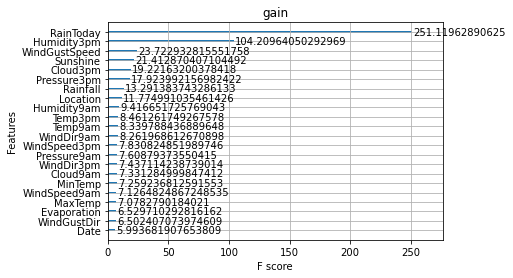

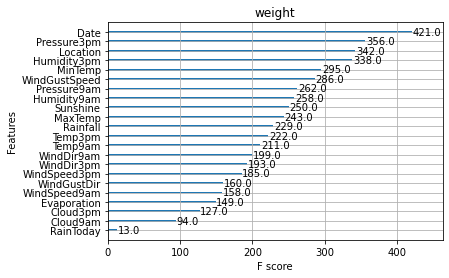

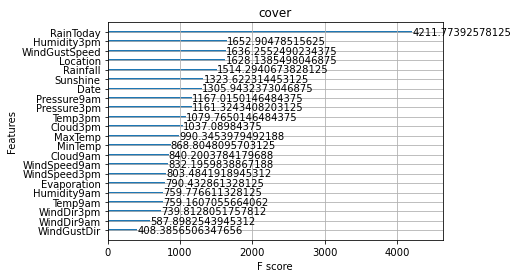

acc= 0.8575179333302076


In [32]:
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

def estimate(model, data):
    ax1 = plot_importance(model, importance_type='gain')
    ax1.set_title('gain')
    ax2 = plot_importance(model, importance_type='weight')
    ax2.set_title('weight')
    ax3 = plot_importance(model, importance_type='cover')
    ax3.set_title('cover')
    plt.show()

def classes(data, label, test):
    model=XGBClassifier()
    model.fit(data, label)
    ans = model.predict(test)
    estimate(model, data)
    return ans

ans = classes(X_tr, y_tr, X_te)
pre = accuracy_score(y_te, ans)
print("acc=", accuracy_score(y_te, ans))

#### Parameters tunning
+ learning_rate: iteration step length. 有时也叫作eta，系统默认值为0.3。每一步迭代的步长，很重要。太大了运行准确率不高，太小了运行速度慢。
+ subsample：for each tree, randomly sampleing ratio. 系统默认为1。这个参数控制对于每棵树，随机采样的比例。减小这个参数的值，算法会更加保守，避免过拟合, 取值范围零到一。
+ colsample_bytree：系统默认值为1。我们一般设置成0.8左右。用来控制每棵随机采样的列数的占比(每一列是一个特征)。
+ max_depth： max depth of a tree. 系统默认值为6，我们常用3-10之间的数字。这个值为树的最大深度。这个值是用来控制过拟合的。max_depth越大，模型学习的更加具体。

调节模型参数的方法有贪心算法、网格调参、贝叶斯调参等。
这里我们采用网格调参，它的基本思想是穷举搜索：在所有候选的参数选择中，通过循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果

In [48]:
# Parameters tunning - Grid Searching
from sklearn.model_selection import GridSearchCV

learning_rate = [0.1, 0.3, 0.5]
subsample = [0.8, 0.9]
colsample_bytree = [0.6, 0.8]
max_depth = [3, 5, 8]

parameters = {'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'max_depth': max_depth}
model = XGBClassifier(n_estimators = 50)
# n_jobs: Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
clf = clf.fit(X_tr, y_tr)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


d:\softs\ANACONDA\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\softs\ANACONDA\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:57:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
# Parameters with the best performance
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.3,
 'max_depth': 8,
 'subsample': 0.9}

In [52]:
# Using the model with best params to predict on Train/Test
clg = XGBClassifier(leanrn_rate=0.3, subsample=0.9, colsample_bytree=0.8, max_depth=8)
clf.fit(X_tr, y_tr)

tr_pred_best = clf.predict(X_tr)
te_pred_best = clf.predict(X_te)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


d:\softs\ANACONDA\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\softs\ANACONDA\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(Best params) The accuracy of the Logistic Regression is : 0.9117036863388619
(Best params) The accuracy of the Logistic Regression is : 0.8562051666744808
(Best params) The confusion matrix result: 
 [[15660  2174]
 [  893  2602]]


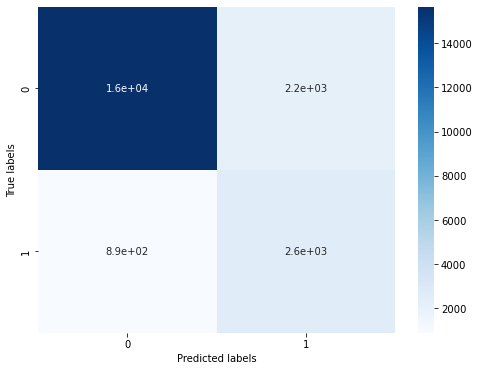

In [54]:
### Evaluation

print('(Best params) The accuracy of the Logistic Regression is :', metrics. accuracy_score(y_tr, tr_pred_best))
print('(Best params) The accuracy of the Logistic Regression is :', metrics. accuracy_score(y_te, te_pred_best))

# confusion matrix
confusion_mat_res_best = metrics.confusion_matrix(te_pred_best, y_te)
print('(Best params) The confusion matrix result: \n', confusion_mat_res_best)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat_res_best, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

+ The original:

In total, there were 15656+2634 samples predicted correctly, 2142+897 samples predicted wrongly.

+ After tunning params:

In total, there were 15660+2602 samples predicted correctly, 2174+893 samples predicted wrongly.

We can see that with the previously 'best' parameters settings, the correct rate on train set imporved, but the accuracy on test decreased, which indicates potential over-fitting.